Load the required libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import obspy
from obspy.signal.konnoohmachismoothing import konno_ohmachi_smoothing

import pykooh

%matplotlib inline

In [2]:
plt.rcParams["figure.dpi"] = 150

# Comparison between the `obspy` and `pykooh`

Load an example time series.

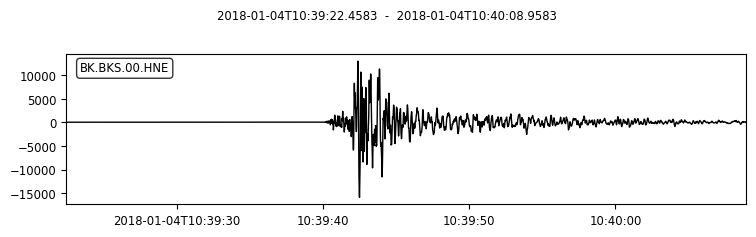

In [37]:
trace = obspy.read("tests/data/example_ts.mseed").traces[0]
trace.plot();

Compute the Fourier amplitudes and apply the smoothing operators.

In [38]:
fourier_amps = trace.stats["delta"] * np.abs(np.fft.rfft(trace.data))
freqs = np.fft.rfftfreq(len(trace), d=trace.stats["delta"])

In [39]:
bw = 188.5
ko_amps = konno_ohmachi_smoothing(fourier_amps, freqs, bw, normalize=True)

In [40]:
pyko_amps = pykooh.smooth(freqs, freqs, fourier_amps, bw)

Plot the smoothing from `obspy` and `pyko`.

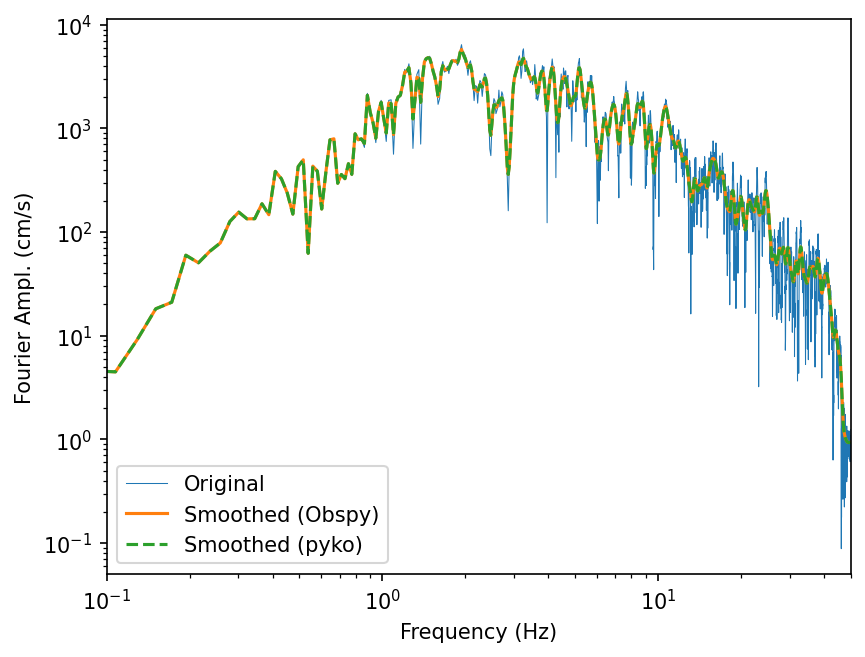

In [41]:
fig, ax = plt.subplots()
ax.plot(freqs, fourier_amps, label="Original", linewidth=0.5)
ax.plot(freqs, ko_amps, label="Smoothed (Obspy)")
ax.plot(freqs, pyko_amps, label="Smoothed (pyko)", linestyle="--")
ax.set(
    xlabel="Frequency (Hz)",
    xscale="log",
    xlim=(0.1, 50),
    ylabel="Fourier Ampl. (cm/s)",
    yscale="log",
)
ax.legend()
fig;

# Calculation time

In [42]:
%time
_ = konno_ohmachi_smoothing(fourier_amps, freqs, bw, normalize=True)

CPU times: user 2 μs, sys: 0 ns, total: 2 μs
Wall time: 4.05 μs


In [51]:
%%time
try:
    _ = pykooh.smooth(freqs, freqs, fourier_amps, bw, use_cython=True)
except ImportError:
    print("Cython not available, skipping timing test.")

Cython not available, skipping timing test.
CPU times: user 58 μs, sys: 0 ns, total: 58 μs
Wall time: 61.3 μs


In [52]:
# Call once to compile numba code
_ = pykooh.smooth(freqs, freqs, fourier_amps, bw, use_cython=False)

In [53]:
%%time
_ = pykooh.smooth(freqs, freqs, fourier_amps, bw, use_cython=False)

CPU times: user 185 ms, sys: 8 μs, total: 185 ms
Wall time: 186 ms


In [ ]:
%%time
_ = pykooh.smooth(freqs, freqs, fourier_amps, bw, use_cython=False, simplified=True)  # noqa

CPU times: user 12.7 ms, sys: 0 ns, total: 12.7 ms
Wall time: 12.8 ms


`Cython` and `numba` implementations provide very similar speed ups.

# Effective amplitude calculation

In [12]:
def read_at2(fname):
    with open(fname) as fp:
        for _ in range(3):
            next(fp)
        time_step = float(next(fp).split()[3])
        accels = np.array([part for line in fp for part in line.split()]).astype(float)
    return time_step, accels

In [13]:
time_step, accels_h1 = read_at2("./tests/data/RSN4863_CHUETSU_65036EW.AT2")
accels_h2 = read_at2("./tests/data/RSN4863_CHUETSU_65036NS.AT2")[1]

accels = np.c_[accels_h1, accels_h2]

In [14]:
fourier_amps = time_step * np.fft.rfft(accels, axis=0)
freqs = np.fft.rfftfreq(accels.shape[0], d=time_step)

In [15]:
freqs_ea, eff_ampl = pykooh.effective_ampl(
    freqs,
    fourier_amps[:, 0],
    fourier_amps[:, 1],
    missing="nan",
    simplified=False,
    bw=40,
)

Mask out the missing values.

In [18]:
mask = ~np.isnan(eff_ampl)

Create a little comparison plot.

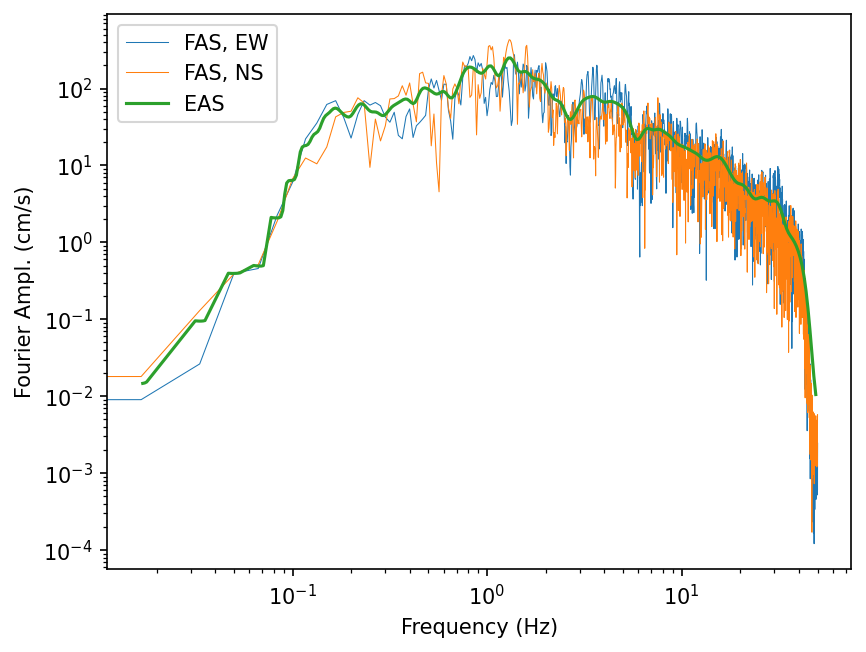

In [19]:
to_cmps = 981.0

fig, ax = plt.subplots()

ax.plot(freqs, np.abs(fourier_amps) * to_cmps, linewidth=0.5)
ax.plot(freqs_ea[mask], eff_ampl[mask] * to_cmps, label="EAS")

ax.set(
    xlabel="Frequency (Hz)", xscale="log", ylabel="Fourier Ampl. (cm/s)", yscale="log"
)
ax.legend(
    ax.get_lines(),
    ["FAS, EW", "FAS, NS", "EAS"],
)
fig;

## Using the CachedSmoother

In [20]:
freqs_sm = np.geomspace(0.1, 50, num=256)

csmoother = pykooh.CachedSmoother(freqs, freqs_sm, bandwidth=40, normalize=True)

fourier_amp_abs = np.abs(fourier_amps[:, 0])

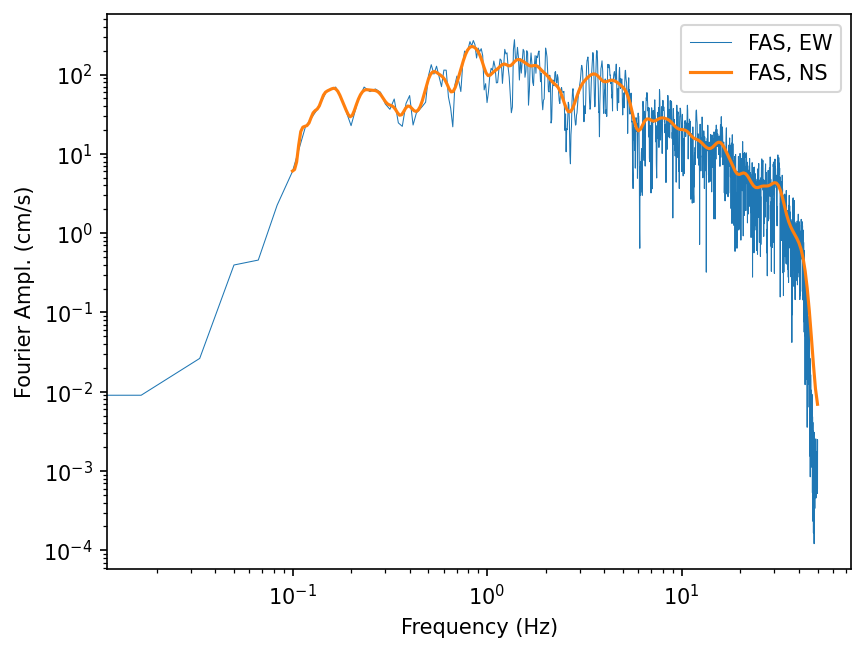

In [21]:
to_cmps = 981.0

fig, ax = plt.subplots()

ax.plot(freqs, fourier_amp_abs * to_cmps, linewidth=0.5)
ax.plot(freqs_sm, csmoother(fourier_amp_abs) * to_cmps, label="Smoothed")
ax.set(
    xlabel="Frequency (Hz)", xscale="log", ylabel="Fourier Ampl. (cm/s)", yscale="log"
)
ax.legend(
    ax.get_lines(),
    ["FAS, EW", "FAS, NS", "EAS"],
)
fig;

In [22]:
trace = obspy.read("tests/data/example_ts.mseed").traces[0]
fa_raw = trace.stats["delta"] * np.abs(np.fft.rfft(trace.data))
freqs = np.fft.rfftfreq(len(trace), d=trace.stats["delta"])

In [23]:
freqs = freqs.astype(np.float64)
fa_raw = fa_raw.astype(np.float64)

## Compare with obspy

In [24]:
bw = 40

cached = pykooh.CachedSmoother(freqs, freqs, bandwidth=bw, normalize=False)

smoothed = {
    "pykooh-numba": pykooh.smooth(
        freqs, freqs, fa_raw, bw, use_cython=False, normalize=False
    ),
    "pykooh-numba-simpl": pykooh.smooth(
        freqs, freqs, fa_raw, bw, use_cython=False, normalize=False, simplified=True
    ),
    "pykooh-cached": cached(fa_raw),
    "obspy": konno_ohmachi_smoothing(fa_raw, freqs, bw, normalize=False),
}

try:
    smoothed["pykooh-cython"] = pykooh.smooth(
        freqs, freqs, fa_raw, bw, use_cython=True, normalize=False
    )
except ImportError:
    print("Cython not available, skipping pykooh-cython")
    pass

Cython not available, skipping pykooh-cython


In [25]:
for label, sm in smoothed.items():
    ratio = sm / smoothed["obspy"]
    print(f"{label}: {np.min(ratio):.4f} - {np.max(ratio):.4f} ({np.mean(ratio):.2f})")

pykooh-numba: 1.0000 - 1.0000 (1.00)
pykooh-numba-simpl: 0.9379 - 1.0000 (0.99)
pykooh-cached: 1.0000 - 1.0000 (1.00)
obspy: 1.0000 - 1.0000 (1.00)


[Text(0.5, 0, 'Frequency (Hz)'), None, Text(0, 0.5, 'Smoothed / Obspy'), None]

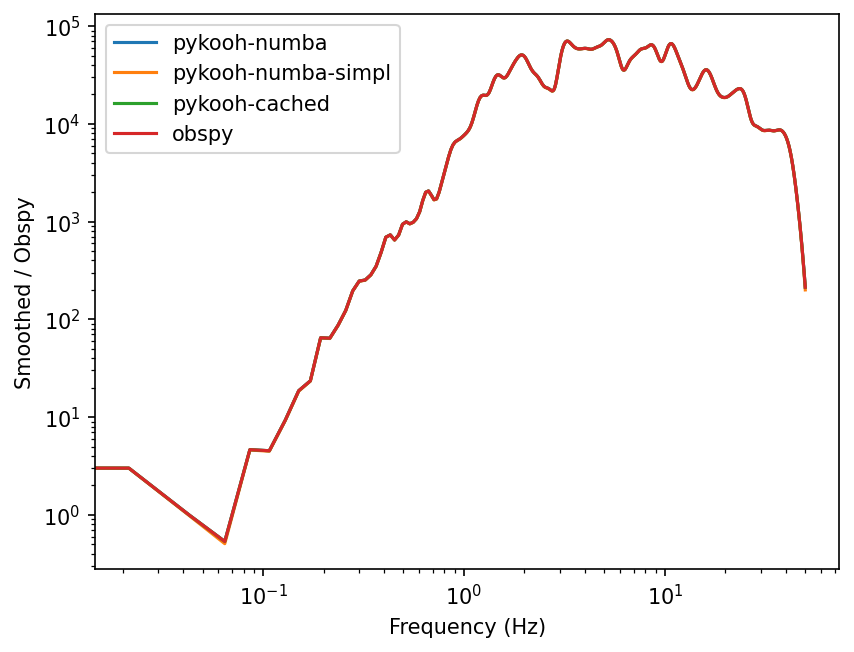

In [26]:
fig, ax = plt.subplots()
for label, smoothed_data in smoothed.items():
    ax.plot(freqs, smoothed_data, label=label)

ax.legend()
ax.set(
    xlabel="Frequency (Hz)",
    xscale="log",
    ylabel="Smoothed / Obspy",
    yscale="log",
)

[Text(0.5, 0, 'Frequency (Hz)'), None, Text(0, 0.5, 'Smoothed / Obspy'), None]

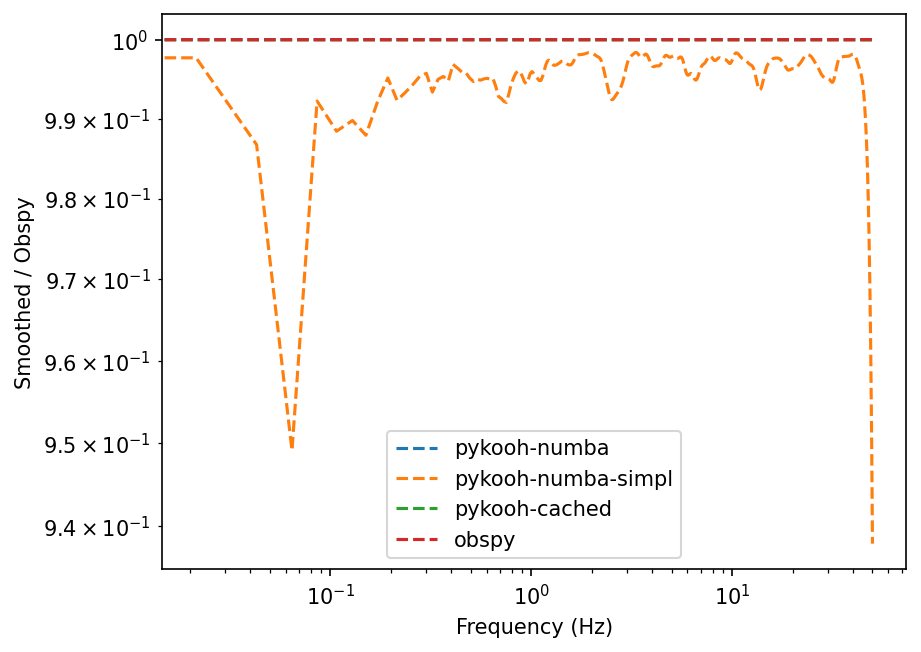

In [27]:
fig, ax = plt.subplots()
for label, smoothed_data in smoothed.items():
    ax.plot(freqs, smoothed_data / smoothed["obspy"], ls="--", label=label)

ax.legend()
ax.set(
    xlabel="Frequency (Hz)",
    xscale="log",
    ylabel="Smoothed / Obspy",
    yscale="log",
)

[Text(0.5, 0, 'Frequency (Hz)'), None, Text(0, 0.5, 'Smoothed / Numba'), None]

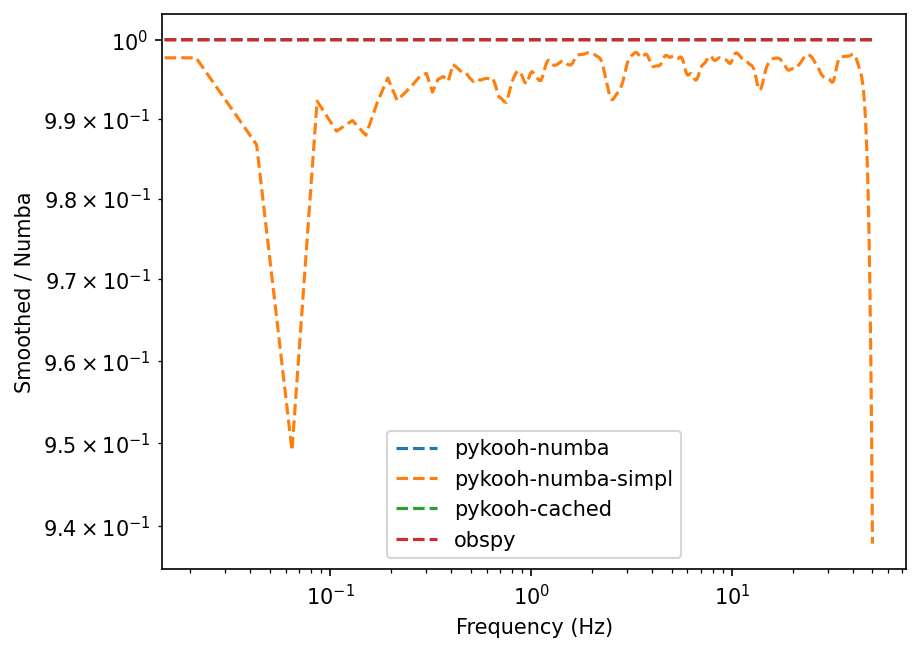

In [28]:
fig, ax = plt.subplots()
for label, smoothed_data in smoothed.items():
    ax.plot(freqs, smoothed_data / smoothed["pykooh-numba"], ls="--", label=label)

ax.legend()
ax.set(
    xlabel="Frequency (Hz)",
    xscale="log",
    ylabel="Smoothed / Numba",
    yscale="log",
)